# PESTPP-GLM Part 2

In this notebook, we will actually run PESTPP-GLM in standard parameter estimation mode and regularization mode.  In both cases, we will use the baked-in bayes-linear posterior monte carlo analysis to get posterior forecast PDFs.  We will use the prior monte carlo outputs as the prior forecast PDF. We will reuse the jacobian we used for FOSM to save runs

In [1]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.size']=12
import flopy
import pyemu


flopy is installed in /Users/jwhite/Dev/mf6flopy2019_Neuchatel/notebooks/dauq/flopy


## SUPER IMPORTANT: SET HOW MANY PARALLEL WORKERS TO USE

In [2]:
num_workers = 20

In [3]:
t_d = "template"
m_d = "master_glm_run"

/Users/jwhite/Dev/mf6flopy2019_Neuchatel/notebooks/dauq/flopy/plot/map.py:1409: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


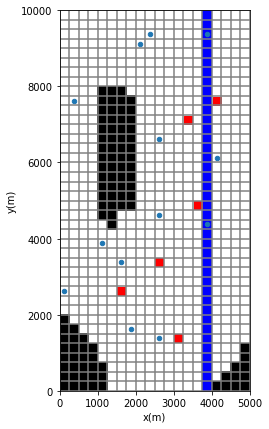

In [4]:
b_d = os.path.join("..","..","data","freyberg_nwt")
nam_file = "freyberg.nam"
m = flopy.modflow.Modflow.load(nam_file,model_ws=b_d,check=False,forgive=False)
# plot some model attributes
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111,aspect="equal")
mm = flopy.plot.ModelMap(model=m)
mm.plot_grid()
mm.plot_ibound()
mm.plot_bc('SFR')
ax = mm.ax
#m.wel.stress_period_data.plot(ax=ax,mflay=2)

# plot obs locations
obs = pd.read_csv(os.path.join(b_d,"obs_loc.csv"))
                  
obs_x = [m.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [m.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='.',label="water-level obs",s=80)

#plot names on the pumping well locations
wel_data = m.wel.stress_period_data[0]
wel_x = m.sr.xcentergrid[wel_data["i"],wel_data["j"]]
wel_y = m.sr.ycentergrid[wel_data["i"],wel_data["j"]]
for i,(x,y) in enumerate(zip(wel_x,wel_y)):
    ax.scatter([x],[y],color="red",marker="s",s=50)
    #ax.text(x,y,"{0}".format(i+1),ha="center",va="center")

ax.set_ylabel("y(m)")
ax.set_xlabel("x(m)")
plt.show()

In [5]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg_pp.pst"))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
cn_hk6,cn_hk6,log,1,0,1,-1,0.5
cn_hk7,cn_hk7,log,1,0,1,-1,0.5
cn_hk8,cn_hk8,log,1,0,1,-1,0.5
cn_rech4,cn_rech4,log,1,0,1,-1,0.5
cn_rech5,cn_rech5,log,1,0,1,-1,0.5
cn_ss6,cn_ss6,log,1,0,1,-1,0.5
cn_ss7,cn_ss7,log,1,0,1,-1,0.5
cn_ss8,cn_ss8,log,1,0,1,-1,0.5
cn_strt6,cn_strt6,log,1,0,0.0211893,-0.0222764,0.0108664
cn_strt7,cn_strt7,log,1,0,0.0211893,-0.0222764,0.0108664


Load and extract the portion of the prior we need for FOSM

In [6]:
cov = pyemu.Cov.from_binary(os.path.join(t_d,"prior_cov.jcb"))
cov.get(pst.adj_par_names).to_ascii(os.path.join(t_d,"glm_prior.cov"))

 set some control options

In [7]:
pst.control_data.noptmax = 3
pst.pestpp_options["n_iter_base"] = -1
pst.pestpp_options["n_iter_super"] = 3
pst.pestpp_options["glm_num_reals"] = 50 # this is how many ies uses
pst.pestpp_options["parcov"] = "glm_prior.cov"
pst.pestpp_options["base_jacobian"] = "freyberg_reuse.jcb"
pst.write(os.path.join(t_d,"freyberg_pp.pst"))

noptmax:3, npar_adj:428, nnz_obs:14


In [8]:
shutil.copy2(os.path.join("master_glm","freyberg_pp.jcb"),
             os.path.join(t_d,"freyberg_reuse.jcb"))

'template/freyberg_reuse.jcb'

In [9]:
pyemu.os_utils.start_workers(t_d,"pestpp-glm","freyberg_pp.pst",num_workers=num_workers,worker_root=".",
                           master_dir=m_d)

In [10]:
df = df=pd.read_csv(os.path.join(m_d,"freyberg_pp.post.obsen.csv"),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

/Users/jwhite/Dev/mf6flopy2019_Neuchatel/notebooks/dauq/pyemu/en.py:365: UserWarning: Ensemble.from_dataframe() is deprecated and has been replaced with the standard constructor, which takesthe same arguments
  warnings.warn("Ensemble.from_dataframe() is deprecated and has been "


real_name
35    2528.036332
40    2558.200187
39    2654.803608
37    2692.357051
25    2825.187588
23    2884.376461
12    2890.799993
26    2946.745708
22    2957.183163
2     2989.287501
24    3010.846011
33    3016.747780
44    3092.851103
20    3101.630355
19    3122.481956
0     3295.534001
32    3316.774949
49    3325.468047
5     3469.360390
17    3517.995777
dtype: float64

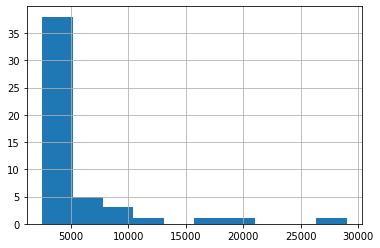

In [11]:
ax = oe.phi_vector.hist()#bins=np.linspace(0,100,20))
oe.phi_vector.sort_values().iloc[:20]

Here we see the distribution of phi values across the 100 posterior realizations.  Should we accept all of these???  The theoretical phi for each realization that we should accept is number of nonzero obs (14).

To get a "posterior" ensemble, we need to throw out the realizations with large phi - lets just take the 20 best:

In [12]:
oe_pt = oe.loc[oe.phi_vector.sort_values().index[:20],:] #just take the 20 lowest phi realizations

We can also load and plot the FOSM forecast results along side of the ensemble results:

In [13]:
f_df = pd.read_csv(os.path.join(m_d,"freyberg_pp.pred.usum.csv"),index_col=0)
f_df.index = f_df.index.map(str.lower)
f_df

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
fa_hw_19791230,-977.2390,1050.85000,-3078.9300,1124.4500,-435.9470,309.513000,-1054.9700,183.0780
fa_hw_19801229,-500.5320,855.25200,-2211.0400,1209.9700,145.9480,709.712000,-1273.4800,1565.3700
fa_tw_19791230,-453.0330,917.67400,-2288.3800,1382.3200,-849.2890,171.259000,-1191.8100,-506.7700
fa_tw_19801229,-11.2061,797.59100,-1606.3900,1583.9800,-0.2249,638.588000,-1277.4000,1276.9500
hds_00_013_002_000,39.6102,4.49166,30.6269,48.5936,39.5742,0.298009,38.9782,40.1702
hds_00_013_002_001,39.0079,3.90166,31.2046,46.8113,38.5132,1.327010,35.8592,41.1672


//miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:316: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


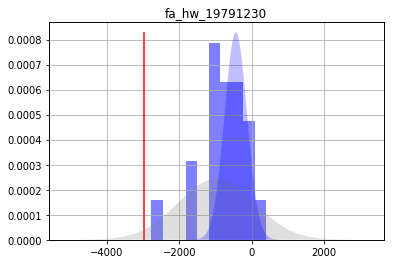

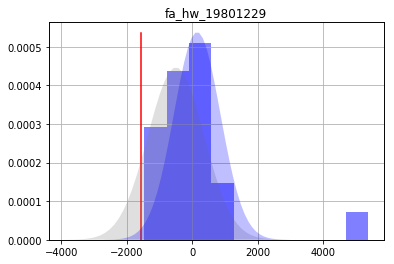

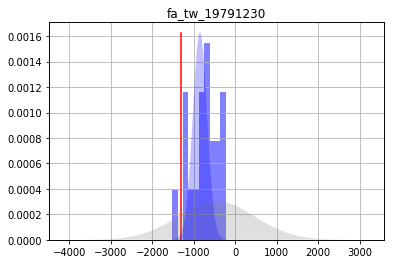

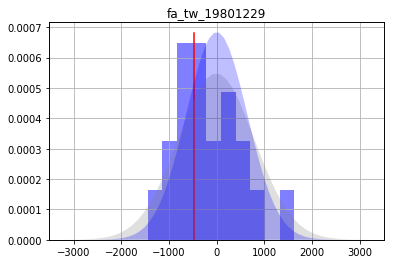

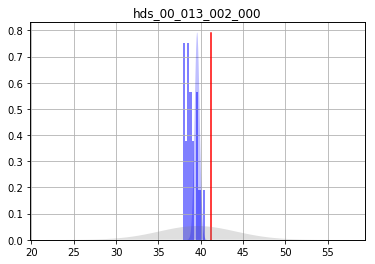

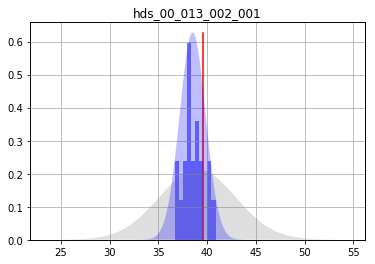

In [14]:
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5,normed=True)
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    axt = plt.twinx()
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"prior_mean"],f_df.loc[forecast,"prior_stdev"])
    axt.fill_between(x,0,y,facecolor="0.5",alpha=0.25)
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"post_mean"],f_df.loc[forecast,"post_stdev"])
    axt.fill_between(x,0,y,facecolor="b",alpha=0.25)
    axt.set_ylim(0,axt.get_ylim()[1])
    axt.set_yticks([])
    ax.set_title(forecast)
    plt.show()

### Check your understanding:  
What assumption did the posterior FOSM Monte Carlo relax? 

### Check your understanding:  
Why didn't the posterior parameter realizations yield a lower phi?  What are the implications of accepting realizations with a higher phi?

### Setup of Tikhonov regularization

Now lets setup and use some formal regularization to bring the final phi up to around 14.  We will use first-order regularization based on the covariance matrix we build earlier:

In [15]:
cov = pyemu.Cov.from_ascii(os.path.join(t_d,"glm_prior.cov"))

In [16]:
pyemu.helpers.first_order_pearson_tikhonov(pst,cov)

getting CC matrix
processing


In [17]:
pst.prior_information.sort_values(by="weight",ascending=False).iloc[-10:]

,pilbl,equation,obgnme,weight
pilbl,,,,
pcc_1956,pcc_1956,1.0 * log(ss003) - 1.0 * log(ss021) = 0.0,regul_cc,0.001221
pcc_704,pcc_704,1.0 * log(hk108) - 1.0 * log(hk131) = 0.0,regul_cc,0.001221
pcc_159,pcc_159,1.0 * log(hk004) - 1.0 * log(hk028) = 0.0,regul_cc,0.001221
pcc_132,pcc_132,1.0 * log(hk003) - 1.0 * log(hk021) = 0.0,regul_cc,0.001221
pcc_248,pcc_248,1.0 * log(hk008) - 1.0 * log(hk031) = 0.0,regul_cc,0.001221
pcc_1500,pcc_1500,1.0 * log(rech003) - 1.0 * log(rech021) = 0.0,regul_cc,0.001221
pcc_1590,pcc_1590,1.0 * log(rech007) - 1.0 * log(rech025) = 0.0,regul_cc,0.001221
pcc_1616,pcc_1616,1.0 * log(rech008) - 1.0 * log(rech031) = 0.0,regul_cc,0.001221
pcc_1527,pcc_1527,1.0 * log(rech004) - 1.0 * log(rech028) = 0.0,regul_cc,0.001221


In [18]:
pst.reg_data.phimlim = pst.nnz_obs
pst.reg_data.phimaccept = pst.reg_data.phimlim * 1.1
pst.pestpp_options["glm_num_reals"] = 50
pst.write(os.path.join(t_d,"freyberg_pp.pst"))

noptmax:3, npar_adj:428, nnz_obs:14


In [19]:
pyemu.os_utils.start_workers(t_d,"pestpp-glm","freyberg_pp.pst",num_workers=num_workers,worker_root=".",
                           master_dir=m_d)

In [20]:
df = df=pd.read_csv(os.path.join(m_d,"freyberg_pp.post.obsen.csv"),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

real_name
35    2528.036332
40    2558.200187
39    2654.803608
37    2692.357051
25    2825.187588
23    2884.376461
12    2890.799993
26    2946.745708
22    2957.183163
2     2989.287501
24    3010.846011
33    3016.747780
44    3092.851103
20    3101.630355
19    3122.481956
0     3295.534001
32    3316.774949
49    3325.468047
5     3469.360390
17    3517.995777
dtype: float64

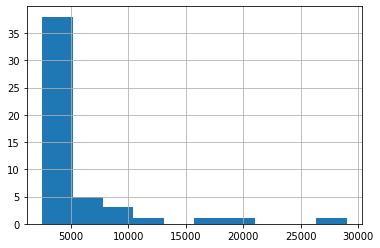

In [21]:
ax = oe.phi_vector.hist()#bins=np.linspace(0,100,20))
oe.phi_vector.sort_values().iloc[:20]

Same as before, to get a "posterior" ensemble, we need to throw out the realizations with large phi - lets just take the 20 best:

In [22]:
oe_pt = oe.loc[oe.phi_vector.sort_values().index[:20],:] 

In [23]:
f_df = pd.read_csv(os.path.join(m_d,"freyberg_pp.pred.usum.csv"),index_col=0)
f_df.index = f_df.index.map(str.lower)
f_df

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
fa_hw_19791230,-977.2390,1050.85000,-3078.9300,1124.4500,-435.9470,309.513000,-1054.9700,183.0780
fa_hw_19801229,-500.5320,855.25200,-2211.0400,1209.9700,145.9480,709.712000,-1273.4800,1565.3700
fa_tw_19791230,-453.0330,917.67400,-2288.3800,1382.3200,-849.2890,171.259000,-1191.8100,-506.7700
fa_tw_19801229,-11.2061,797.59100,-1606.3900,1583.9800,-0.2249,638.588000,-1277.4000,1276.9500
hds_00_013_002_000,39.6102,4.49166,30.6269,48.5936,39.5742,0.298009,38.9782,40.1702
hds_00_013_002_001,39.0079,3.90166,31.2046,46.8113,38.5132,1.327010,35.8592,41.1672


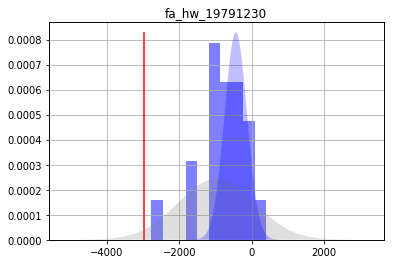

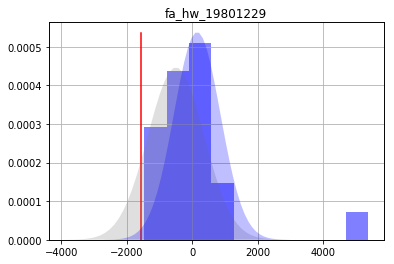

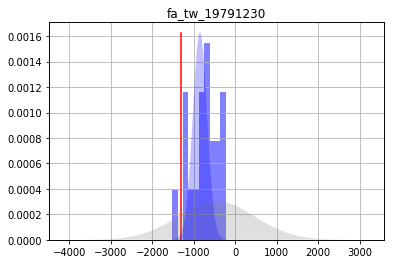

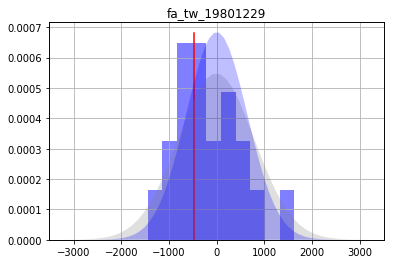

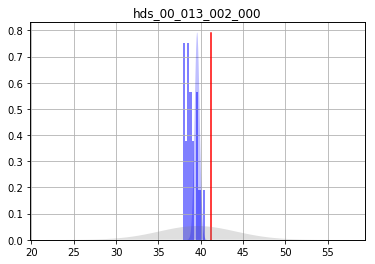

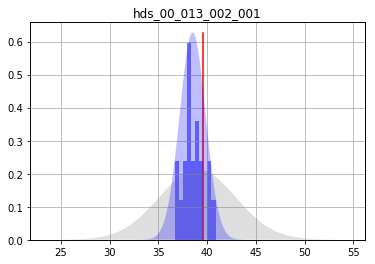

In [24]:
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5,normed=True)
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    axt = plt.twinx()
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"prior_mean"],f_df.loc[forecast,"prior_stdev"])
    axt.fill_between(x,0,y,facecolor="0.5",alpha=0.25)
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"post_mean"],f_df.loc[forecast,"post_stdev"])
    axt.fill_between(x,0,y,facecolor="b",alpha=0.25)
    axt.set_ylim(0,axt.get_ylim()[1])
    axt.set_yticks([])
    ax.set_title(forecast)
    plt.show()